## Prepare the inputs

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import scipy.misc
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')

### Prepare data -- Training
dataset: choose train dataset or test dataset

In [16]:
image_size = 33
label_size = 21
scale = 3

In [11]:
# Load data path
dataset = 'Train'
data_dir = os.path.join(os.getcwd(), dataset)
data = glob.glob(os.path.join(data_dir, "*.bmp"))

In [13]:
sub_input_sequence = []
sub_label_sequence = []
padding = abs(image_size - label_size)/2

In [67]:
def preprocess(path, scale):
    """
    Preprocess single image file:
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
    
    Args:
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
    """
    image = imread(path, is_grayscale=True)
    label_ = modcrop(image,scale)
    
    #Normalized
    image = image / 255
    label_ = label_ / 255
    
    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
    
    return input_, label_

In [30]:
def imread(path, is_grayscale=True):
    if is_grayscale:
        return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
    else:
        return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

In [31]:
def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [32]:
for i in range(len(data)):
    if i%10 == 0:
        input_, label_ = preprocess(data[i], scale)

/Users/cozg3/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


## Display Input and Groundtruth

(174, 195)
(174, 195)


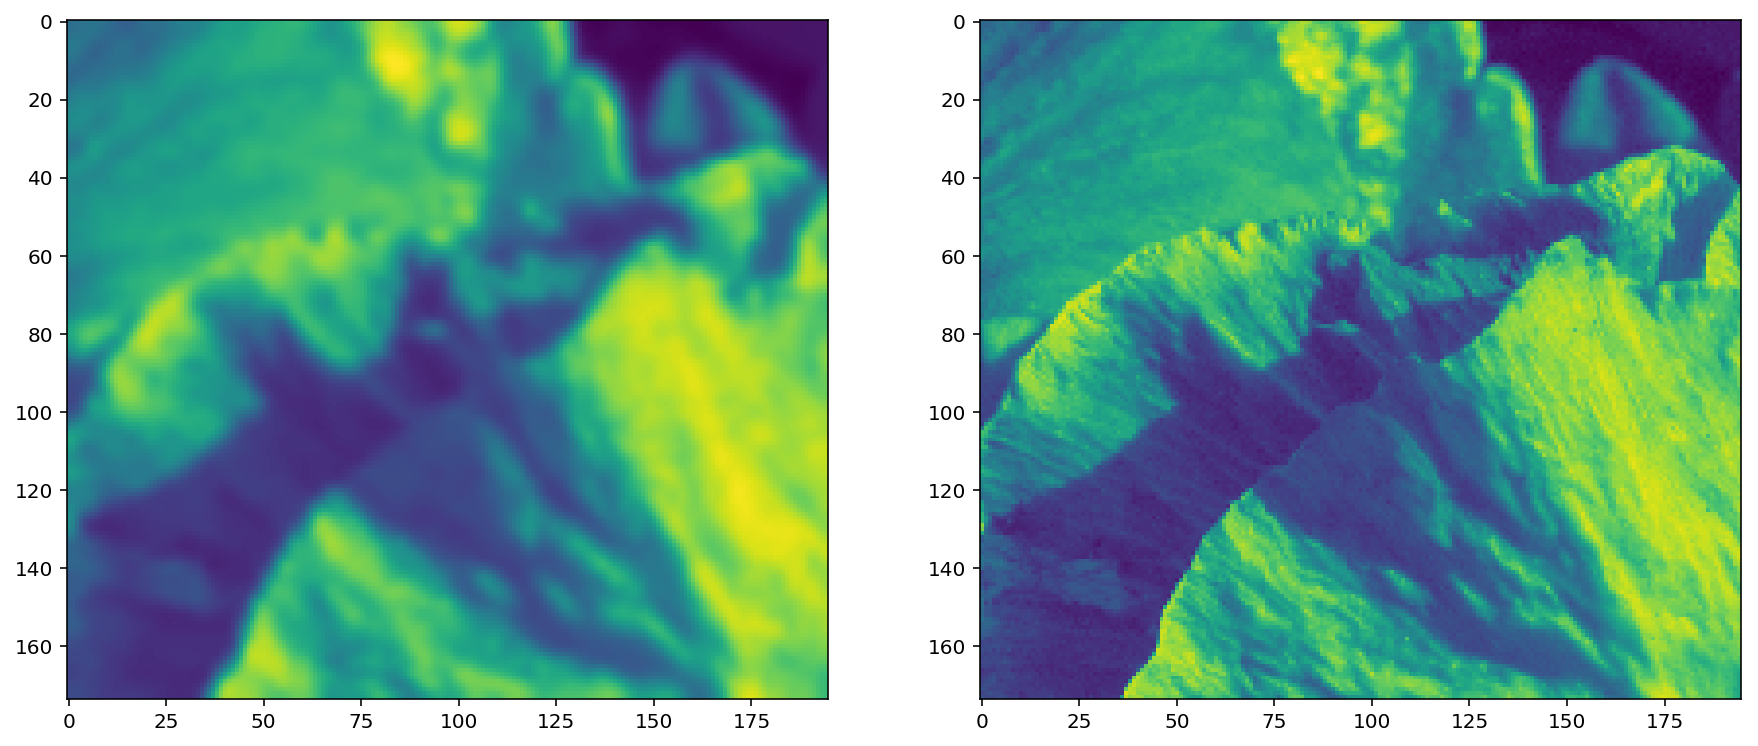

In [73]:
input_, label_ = preprocess(data[0], scale)
plt.figure(figsize=(15,15))
for i, image in enumerate([input_,label_]):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)